# Image Captioning Final Project

In this final project you will define and train an image-to-caption model, that can produce descriptions for real world images!

<img src="https://github.com/hse-aml/intro-to-dl-pytorch/blob/main/week06/images/encoder_decoder.png?raw=1" style="width:70%">

Model architecture: CNN encoder and RNN decoder. 
(https://research.googleblog.com/2014/11/a-picture-is-worth-thousand-coherent.html)

Alright, here's our plan:
* Take a pre-trained inception v3 to vectorize images
* Stack an LSTM on top of it
* Train the thing on MSCOCO

## Importing stuff and preparing data

In [1]:
%%bash

shred -u setup_colab.py

wget https://raw.githubusercontent.com/hse-aml/intro-to-dl-pytorch/main/utils/setup_colab.py -O setup_colab.py

--2022-12-15 13:44:08--  https://raw.githubusercontent.com/hse-aml/intro-to-dl-pytorch/main/utils/setup_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1649 (1.6K) [text/plain]
Saving to: ‘setup_colab.py’

     0K .                                                     100% 15.6M=0s

2022-12-15 13:44:08 (15.6 MB/s) - ‘setup_colab.py’ saved [1649/1649]



In [2]:
import setup_colab

setup_colab.setup_week06()

In [3]:
%%time

# Load dataset (vectorized images and captions)
import numpy as np
import json

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

CPU times: user 179 ms, sys: 375 ms, total: 554 ms
Wall time: 553 ms


In [4]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [5]:
# split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"] + sentence.split(' ') + ["#END#"]

# [[['#START#',
#    'people',
#    'shopping',
#    'in',
#    'an',
#    'open',
#    'market',
#    'for',
#    'vegetables',
#    '.',
#    '#END#'],
#   ...
#    [...,
#    'air',
#    'market',
#    '.',
#    '#END#']],
#    ...]

You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts.

We want you to count the occurences of each word so that we can decide which words to keep in our vocabulary.

In [6]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

# Compute word frequencies for each word in captions. See code above for data structure

# YOUR CODE HERE
for captions_img in captions:
  for caption in captions_img:
    word_counts.update(caption)

In [7]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

# {'#UNK#': 0,
#  '#START#': 1,
#  '#END#': 2,
#  '#PAD#': 3,
#  'people': 4,
#  'shopping': 5,
#  'in': 6,
#  'an': 7,
#  'open': 8,
#  'market': 9,
#  'for': 10,
#  'vegetables': 11,
#  '.': 12,

In [8]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [9]:
# Try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   24,  262,  140,    6,  159,   14,   24,  858,  155,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  155,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   41,   18,  903,   35,  620,  155,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   45,  115,  262,   41,   53,   18,  620, 1525,   77,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  123,   58,   45,  276,
        3641,   24, 3642,   35,   45, 1128,   12,    2]], dtype=int32)

## Building our neural network
As we mentioned earlier, we shall build an rnn "language-model" conditioned on vectors from the convolutional part.

<img src="https://github.com/yunjey/pytorch-tutorial/raw/master/tutorials/03-advanced/image_captioning/png/model.png" style="width:70%">

In [10]:
import torch
from torch import nn
import torch.nn.functional as F

In [11]:
class CaptionNet(nn.Module):
    
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super().__init__()
        
        # a layer that converts conv features to initial_h (h_0) and initial_c (c_0)
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)

        # create embedding for input words. Use the parameters (e.g. emb_size).
        # YOUR CODE HERE
        self.emb = nn.Embedding(n_tokens, emb_size)
            
        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True
        # YOUR CODE HERE
        self.lstm = nn.LSTM(emb_size, lstm_units, batch_first = True) #cnn_feature_size
            
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        # YOUR CODE HERE
        self.logits = nn.Linear(lstm_units, n_tokens)
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        self.lstm.flatten_parameters()

        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
        # compute embeddings for captions_ix
        # YOUR CODE HERE
        captions_emb = self.emb(captions_ix)
        
        # apply recurrent layer to captions_emb. 
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        # YOUR CODE HERE

        # captions_emb - [5, 16, 128]
        # initial_cell - [5, 256]
        # initial_hid  - [5, 256]
        # RuntimeError: Expected hidden[0] size (2048, 5, 256)
        lstm_out = self.lstm(captions_emb, (initial_cell[None], initial_hid[None]))[0]
        
        # compute logits from lstm_out
        # YOUR CODE HERE
        logits = self.logits(lstm_out)
        return logits

In [12]:
network = CaptionNet(n_tokens)

In [13]:
# ! pkill -9 python3

In [14]:
dummy_img_vec = torch.randn(len(captions[0]), 2048)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [15]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: crossentropy (neg llh) loss for next captions_ix given previous ones. Scalar float tensor
    """
    
    # captions for input - all except last because we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)
    
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask!
    # Make sure that predicting next tokens after EOS do not contribute to loss
    # You can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.
    
    # YOUR CODE HERE
    criterion = nn.CrossEntropyLoss(ignore_index = pad_ix)
    loss = criterion(logits_for_next.reshape((-1, logits_for_next.shape[2])), captions_ix_next.reshape(-1)) 
    return loss

In [16]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert len(dummy_loss.shape) <= 1, 'loss must be scalar'
assert dummy_loss.data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
    'loss should depend differentiably on all neural network weights'

## Batch generator

In [17]:
from sklearn.model_selection import train_test_split

captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(
    img_codes, captions, test_size=0.1, random_state=42
)

<ipython-input-17-236c0e7c1484>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  captions = np.array(captions)


In [18]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    # sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    # get images
    batch_images = img_codes[random_image_ix]
    
    # 5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    # pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    # convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32), \
        torch.tensor(batch_captions_ix, dtype=torch.int64)

In [19]:
generate_batch(img_codes, captions, 3)

(tensor([[0.4368, 0.0266, 0.2816,  ..., 0.0799, 0.3407, 0.0171],
         [0.1984, 0.9386, 0.1542,  ..., 0.1864, 0.0472, 0.0298],
         [0.3470, 0.5283, 0.5514,  ..., 0.1158, 0.2179, 0.2296]]),
 tensor([[   1,   24,   57,  170,  541,  920,  185,   24, 5873, 1226,    2,    3,
             3],
         [   1,   24,  115,  262,   58,  839,  485,  620, 1165, 6259,   12,    2,
             3],
         [   1,   24,   29,   41,  140,   35,   24, 1844,  301,  163, 3334,   12,
             2]]))

## Train and validate loop

In [20]:
from tqdm import tqdm_notebook
from IPython.display import clear_output
from tqdm import tqdm

In [21]:
DEVICE = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [22]:
network = CaptionNet(n_tokens).to(DEVICE)
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)

batch_size = 128
n_epochs = 100
n_batches_per_epoch = 50
n_validation_batches = 5  # how many batches are used for validation after each epoch

In [23]:
for epoch in range(n_epochs):
    
    train_loss = 0
    network.train()
    for _ in tqdm(range(n_batches_per_epoch)):
        images, captions = generate_batch(train_img_codes, train_captions, batch_size)
        images = images.to(DEVICE)
        captions = captions.to(DEVICE)

        loss_t = compute_loss(network, images, captions)
        
        # clear old gradients; do a backward pass to get new gradients; then train with opt
        # YOUR CODE HERE
        network.zero_grad()
        loss_t.backward()
        optimizer.step()
        
        train_loss += loss_t.detach().cpu().numpy()
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    network.eval()
    for _ in range(n_validation_batches):
        images, captions = generate_batch(val_img_codes, val_captions, batch_size)
        images = images.to(DEVICE)
        captions = captions.to(DEVICE)
        
        with torch.no_grad():
            loss_t = compute_loss(network, images, captions)

        val_loss += loss_t.detach().cpu().numpy()

    val_loss /= n_validation_batches
    
    clear_output()
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")


Epoch: 99, train loss: 2.476819462776184, val loss: 2.5733580112457277
Finished!


## Generating caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [24]:
from beheaded_inception3 import beheaded_inception_v3

inception = beheaded_inception_v3().eval()

def generate_caption(image, caption_prefix = ('#START#',), t=1, sample=True, max_len=100):
    global network
    network = network.cpu().eval()

    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >= 0 and image.shape[-1] == 3
    
    image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)
    
    vectors_8x8, vectors_neck, logits = inception(image[None])
    caption_prefix = list(caption_prefix)
    
    for _ in range(max_len):
        
        prefix_ix = as_matrix([caption_prefix])
        prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
        next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
        next_word_probs = F.softmax(next_word_logits, -1).detach().numpy()
        
        assert len(next_word_probs.shape) == 1, 'probs must be one-dimensional'
        next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

        if sample:
            next_word = np.random.choice(vocab, p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption_prefix.append(next_word)

        if next_word == '#END#':
            break

    return ' '.join(caption_prefix[1:-1])

/usr/local/lib/python3.8/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [25]:
import matplotlib.pyplot as plt
from skimage.transform import resize

# sample image
! wget https://avatars.mds.yandex.net/get-zen_doc/1578906/pub_5deb7d24a06eaf00af983448_5deb7d6643863f00ae06dc24/scale_1200 -O data/img.jpg

--2022-12-15 13:49:02--  https://avatars.mds.yandex.net/get-zen_doc/1578906/pub_5deb7d24a06eaf00af983448_5deb7d6643863f00ae06dc24/scale_1200
Resolving avatars.mds.yandex.net (avatars.mds.yandex.net)... 87.250.247.184, 87.250.247.181, 87.250.247.182, ...
Connecting to avatars.mds.yandex.net (avatars.mds.yandex.net)|87.250.247.184|:443... connected.
HTTP request sent, awaiting response... 410 Gone
2022-12-15 13:49:03 ERROR 410: Gone.



In [26]:
# img = plt.imread('data/img.jpg')
# img = resize(img, (299, 299))

# plt.imshow(img)

# for i in range(5):
#     print(generate_caption(img, t=5.))

The link doesn't work

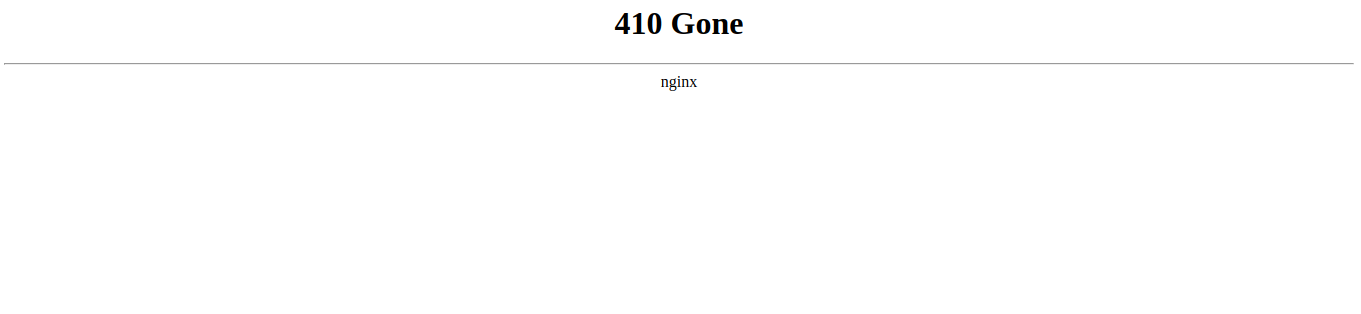

# Staff graded assignment tasks

Now you are going to train the network and estimate it's quality on checkpoints.

1. Train the network for 6 epoches (set n_batches_per_epoch to such value, that with batch_size you iterate over the whole dataset at one epoch, you should increase n_validation_batches to validate more accurately), find good and bad annotation examples. What loss values have you achieved?
1. Continue training until 12 epoch. What happened to the loss value? Search for examples, that have improved their captions in comparison to 6 epoch training.
1. Train the network until convergence. How many epoches do you need?
1. Mobile devices are not very powerfull. Try reducing network size (emb_size=64, lstm_units=128), how it affected network quality after 12 epoches in comparison to original network? And visually?
1. Collect at least 10 images that you like to test our network on.
    - Seriously, that's part of an assignment. Go get at least 10 pictures to get captioned
    - Make sure it works okay on simple images before going to something more complex
    - Photos, not animation/3d/drawings, unless you want to train CNN network on anime
    - Mind the aspect ratio
    - Photos should not be from MSCOCO! Collect some data yourself, take anything you find worth testing on

### Training tips

* If training loss has become close to 0 or model produces garbage, double-check that you're predicting next words, not current or t+2'th words
* If the model generates fluent captions that have nothing to do with the images
    * this may be due to recurrent net not receiving image vectors.
    * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
    * finally, you may just need to train the model a bit more
* Crossentropy is a poor measure of overfitting
    * Model can overfit validation crossentropy but keep improving validation quality.
    * Use human (manual) evaluation or try automated metrics: cider or bleu
    
* We recommend you to periodically evaluate the network using the next "apply trained model" block
    * its safe to interrupt training, run a few examples and start training again
* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=2.8 ~ 3.0

## Images to test on

We have downloaded 30 images from validation set of MSCOCO, they are located in `data` folder and named `img_i.jpg` for i from 0 to 29. You should use them to measure your network quality during checkpoints.

In [27]:
### READ IMAGES FROM DISK
images_30 = []
for i in range(30):
    image_tr = plt.imread(f'data/img_{i}') / 255.
    image_tr = resize(image_tr, (299, 299))
    images_30.append(image_tr)

## First task

Train the network for 6 epoches (set n_batches_per_epoch to such value, that with batch_size you iterate over the whole dataset at one epoch, you should increase n_validation_batches to validate more accurately), find good and bad annotation examples. What loss values have you achieved?

In [28]:
### USE CODE FROM ABOVE (MAIN TRAIN AND VAL LOOP)
### USE CODE FROM ABOVE (GENERATING CAPTION FOR IMAGES)

import math


network = CaptionNet(n_tokens).to(DEVICE)
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)

# batch_size = 128 # default
n_epochs = 6
n_batches_per_epoch = math.ceil(img_codes.shape[0] / batch_size) # iterate over the whole dataset at one epoch
n_validation_batches = round(n_batches_per_epoch*5/50)           # Let's leave as before, the same ratio 
                                                                 # of the training sample in one epoch and the validation one

for epoch in range(n_epochs):
    
    train_loss = 0
    network.train()
    for _ in tqdm(range(n_batches_per_epoch)):
        images, captions = generate_batch(train_img_codes, train_captions, batch_size)
        images = images.to(DEVICE)
        captions = captions.to(DEVICE)

        loss_t = compute_loss(network, images, captions)
        
        # clear old gradients; do a backward pass to get new gradients; then train with opt
        # YOUR CODE HERE
        network.zero_grad()
        loss_t.backward()
        optimizer.step()
        
        train_loss += loss_t.detach().cpu().numpy()
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    network.eval()
    for _ in range(n_validation_batches):
        images, captions = generate_batch(val_img_codes, val_captions, batch_size)
        images = images.to(DEVICE)
        captions = captions.to(DEVICE)
        
        with torch.no_grad():
            loss_t = compute_loss(network, images, captions)

        val_loss += loss_t.detach().cpu().numpy()

    val_loss /= n_validation_batches
    
    clear_output()
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")


Epoch: 5, train loss: 2.4877293911495726, val loss: 2.5430785262066387
Finished!


Now let's find good and bad annotation examples.

In [29]:
for i in images_30:
    print(generate_caption(i, t=5.))
    plt.imshow(i);
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

The good annotations were as follows:
- a bus that is parked in front of a building .
- a bear that is standing in the grass .
- a man flying a kite on the beach .
- a clock tower with a clock on top .
- a young boy is swinging a bat at a ball .
- a group of people standing around a cake .
- a giraffe standing in the grass near a tree .
- a double decker bus is parked in front of a building .
- a man is riding a snowboard down a snow covered slope .
- a group of people sitting at a table with a laptop .

Many of the others were logical and close to the ideal description. But some were absolutely meaningless, like "a bench sitting on a bench..".

And the loss value - 2.54

## Second task

Continue training until 12 epoch. What happened to the loss value? Search for examples, that have improved their captions in comparison to 6 epoch training.

In [30]:
### USE CODE FROM ABOVE (MAIN TRAIN AND VAL LOOP)
### USE CODE FROM ABOVE (GENERATING CAPTION FOR IMAGES)

network = CaptionNet(n_tokens).to(DEVICE)
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)

# batch_size = 128 # default
n_epochs = 12
n_batches_per_epoch = math.ceil(img_codes.shape[0] / batch_size) # iterate over the whole dataset at one epoch
n_validation_batches = round(n_batches_per_epoch*5/50)           # Let's leave as before, the same ratio 
                                                                 # of the training sample in one epoch and the validation one

for epoch in range(n_epochs):
    
    train_loss = 0
    network.train()
    for _ in tqdm(range(n_batches_per_epoch)):
        images, captions = generate_batch(train_img_codes, train_captions, batch_size)
        images = images.to(DEVICE)
        captions = captions.to(DEVICE)

        loss_t = compute_loss(network, images, captions)
        
        # clear old gradients; do a backward pass to get new gradients; then train with opt
        # YOUR CODE HERE
        network.zero_grad()
        loss_t.backward()
        optimizer.step()
        
        train_loss += loss_t.detach().cpu().numpy()
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    network.eval()
    for _ in range(n_validation_batches):
        images, captions = generate_batch(val_img_codes, val_captions, batch_size)
        images = images.to(DEVICE)
        captions = captions.to(DEVICE)
        
        with torch.no_grad():
            loss_t = compute_loss(network, images, captions)

        val_loss += loss_t.detach().cpu().numpy()

    val_loss /= n_validation_batches
    
    clear_output()
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")


Epoch: 11, train loss: 2.3413710862237056, val loss: 2.45752890991128
Finished!


In [31]:
for i in images_30:
    print(generate_caption(i, t=5.))
    plt.imshow(i);
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

The value of the loss function has become really better (decreased by 0.1). As for the pictures whose captions have become better, here they are:
- a double decker bus driving down a street .
- a black bear walking through a grassy field .
- a glass of wine is sitting on a table .
- a statue of a vase of flowers sitting on a table .
- a group of people sitting around a table with a laptop .
- a group of boats are docked in the water .
- etc.

However, there are also those whose signatures have become much worse:
- a horse is standing in a field with a dog .
- a man and a woman are playing with a frisbee .
- a pizza sitting on top of a white plate .

But there were very few of them. Basically everything is pretty close.


## Third task

Train the network until convergence. How many epoches do you need?

For this task we will use `patience`. If it is set to 2 (for example), the training will stop if val loss drops 2 times continuously. 

For our task, we will set this value equal to 2. And we will not stop learning, but simply add an additional output that will signal divergence.

And we will learn on about 50 epochs. After we will output graphs of loss functions on the training and validation samples.

Let's compare the graphs with our result of the divergence detection algorithm.

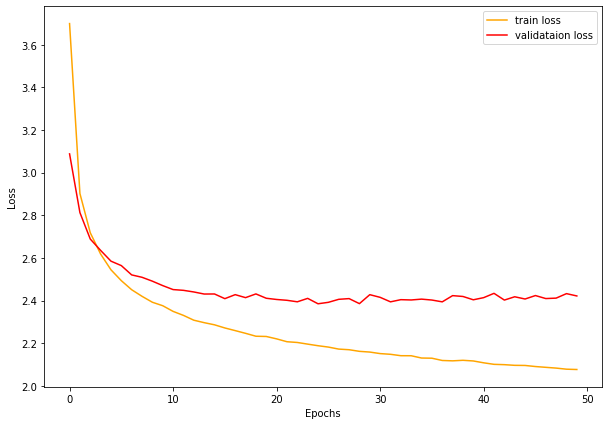


The divergence is fixed at 17 epoch!


In [32]:
### USE CODE FROM ABOVE (MAIN TRAIN AND VAL LOOP)

network = CaptionNet(n_tokens).to(DEVICE)
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)

# batch_size = 128 # default
n_epochs = 50 # try for example
n_batches_per_epoch = math.ceil(img_codes.shape[0] / batch_size) # iterate over the whole dataset at one epoch
n_validation_batches = round(n_batches_per_epoch*5/50)           # Let's leave as before, the same ratio 
                                                                 # of the training sample in one epoch and the validation one

prev_loss = 10
patience = 2
trig = 0
epoch_num = None
train_lst = []
val_lst = []

for epoch in range(n_epochs):
    
    train_loss = 0
    network.train()
    for _ in tqdm(range(n_batches_per_epoch)):
        images, captions = generate_batch(train_img_codes, train_captions, batch_size)
        images = images.to(DEVICE)
        captions = captions.to(DEVICE)

        loss_t = compute_loss(network, images, captions)
        
        # clear old gradients; do a backward pass to get new gradients; then train with opt
        # YOUR CODE HERE
        network.zero_grad()
        loss_t.backward()
        optimizer.step()
        
        train_loss += loss_t.detach().cpu().numpy()
        
    train_loss /= n_batches_per_epoch
    train_lst.append(train_loss)
    
    val_loss = 0
    network.eval()
    for _ in range(n_validation_batches):
        images, captions = generate_batch(val_img_codes, val_captions, batch_size)
        images = images.to(DEVICE)
        captions = captions.to(DEVICE)
        
        with torch.no_grad():
            loss_t = compute_loss(network, images, captions)

        val_loss += loss_t.detach().cpu().numpy()

    val_loss /= n_validation_batches
    val_lst.append(val_loss)

    if epoch_num == None and val_loss > prev_loss:
        trig += 1
        if trig >= patience:
            epoch_num = epoch+1 # we add one, because we take into account the beginning of learning from the 0 epoch, and not from 1

    prev_loss = val_loss
    
    clear_output()
    # print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    plt.figure(figsize=(10, 7))
    plt.plot(train_lst, color='orange', label='train loss')
    plt.plot(val_lst, color='red', label='validataion loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


print()
print('The divergence is fixed at {} epoch!'.format(epoch_num))

Since we set the sign of patience equal to 2, thanks to our algorithm we got the epoch number 17 (considering the 0 epoch as the 1st). 

So it is. Starting from the 17th epoch, there is a clear discrepancy.

If we set the sign of patience equal to 1, we would get a result that fixed the last epoch of convergence - 15 (based on the graph)

## Fourth task

 Mobile devices are not very powerfull. Try reducing network size (emb_size=64, lstm_units=128), how it affected network quality after 12 epoches in comparison to original network? And visually?

In [33]:
### USE CODE FROM ABOVE (MAIN TRAIN AND VAL LOOP)
### USE CODE FROM ABOVE (GENERATING CAPTION FOR IMAGES)

network = CaptionNet(n_tokens, emb_size=64, lstm_units=128).to(DEVICE)
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)

# batch_size = 128 # default
n_epochs = 12
n_batches_per_epoch = math.ceil(img_codes.shape[0] / batch_size) # iterate over the whole dataset at one epoch
n_validation_batches = round(n_batches_per_epoch*5/50)           # Let's leave as before, the same ratio 
                                                                 # of the training sample in one epoch and the validation one

for epoch in range(n_epochs):
    
    train_loss = 0
    network.train()
    for _ in tqdm(range(n_batches_per_epoch)):
        images, captions = generate_batch(train_img_codes, train_captions, batch_size)
        images = images.to(DEVICE)
        captions = captions.to(DEVICE)

        loss_t = compute_loss(network, images, captions)
        
        # clear old gradients; do a backward pass to get new gradients; then train with opt
        # YOUR CODE HERE
        network.zero_grad()
        loss_t.backward()
        optimizer.step()
        
        train_loss += loss_t.detach().cpu().numpy()
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    network.eval()
    for _ in range(n_validation_batches):
        images, captions = generate_batch(val_img_codes, val_captions, batch_size)
        images = images.to(DEVICE)
        captions = captions.to(DEVICE)
        
        with torch.no_grad():
            loss_t = compute_loss(network, images, captions)

        val_loss += loss_t.detach().cpu().numpy()

    val_loss /= n_validation_batches
    
    clear_output()
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")


Epoch: 11, train loss: 2.5265354705501246, val loss: 2.5967795045479485
Finished!


In [34]:
for i in images_30:
    print(generate_caption(i, t=5.))
    plt.imshow(i);
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

Regarding network quality, we get a difference with the original network of 0.15 on validation samples.

Well, visually, the quality of captions has deteriorated significantly. There was a predominance of contradictory descriptions of images.

It turns out that the difference of 0.15 is quite large.

## Fifth task

Collect at least 10 images that you like to test our network on.
   - Seriously, that's part of an assignment. Go get at least 10 pictures to get captioned
   - Make sure it works okay on simple images before going to something more complex
   - Photos, not animation/3d/drawings, unless you want to train CNN network on anime
   - Mind the aspect ratio
   - Photos should not be from MSCOCO! Collect some data yourself, take anything you find worth testing on

I uploaded the photos to Google drive. I attached the archive with the photo to the task.

In [35]:
### YOUR IMAGES COLLECTING CODE
import os
from google.colab import drive
drive.mount('/content/drive')

images_10 = []
dir = os.getcwd() + '/drive/My Drive/Colab Notebooks/foto_for_final_project'
foto = os.listdir(dir)
for i in foto:
    image_tr = plt.imread(dir+f'/{i}') / 255.
    image_tr = resize(image_tr, (299, 299))
    images_10.append(image_tr)

Mounted at /content/drive


a dog sitting on a chair in a room .


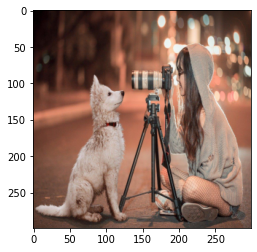

a small bird sitting on a small white plate .


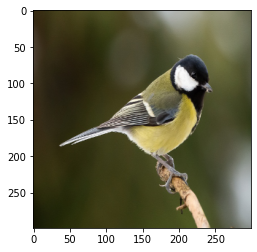

a street with a lot of cars and trucks .


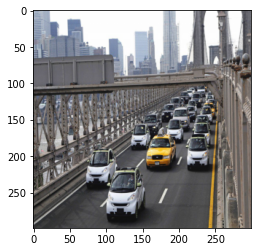

a dog is laying on a rock on a sunny day .


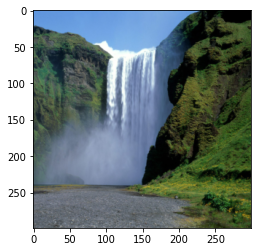

a group of people playing soccer on a field .


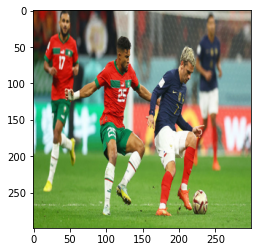

a person riding skis down a snow covered slope .


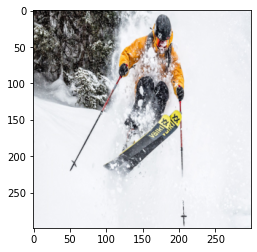

a man is sitting on a bench in a room .


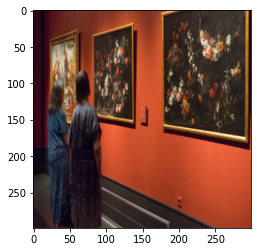

a kitchen with a stove and a stove


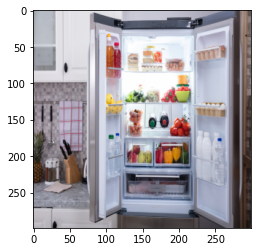

a red and white bird sitting on a tree .


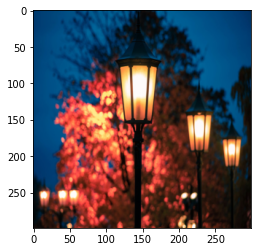

a white and white cat sitting on top of a wooden table .


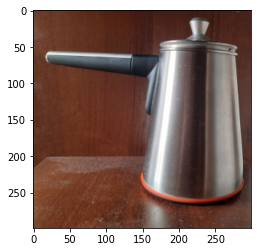

In [36]:
### YOUR CAPTIONS GENERATING CODE
for i in images_10:
    print(generate_caption(i, t=5.))
    plt.imshow(i);
    plt.show()

We received different descriptions, both good and bad. Let's try to generate them again. There are 5 pieces for each photo.

a dog is standing in front of a car .
a dog is standing in front of a car .
a dog is standing in front of a truck .
a dog is sitting on a chair in a chair .
a dog is standing in front of a truck .


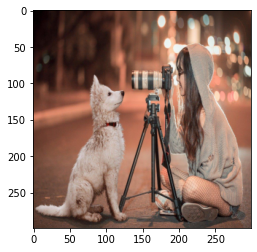

a bird is sitting on a small white plate .
a small bird sitting on a wooden table .
a bird sitting on a rock next to a tree .
a small bird sitting on a rock in a small white .
a bird sitting on a branch of a tree .


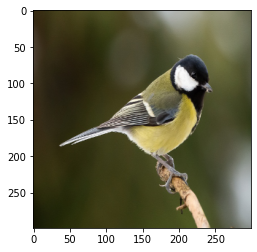

a bus is parked in the middle of a street .
a street with a lot of cars and buses .
a street with a lot of cars and cars parked on the side of it .
a street with a lot of cars and cars parked on the side of it .
a street with a lot of cars and cars parked on the side of it .


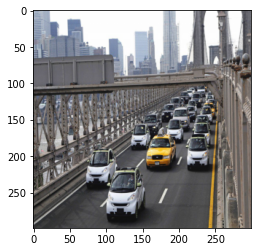

a dog on a leash near a tree .
a large brown dog on a leash next to a river .
a dog on a leash on a dirt road .
a person on a dirt road with a dog .
a dog on a leash next to a tree .


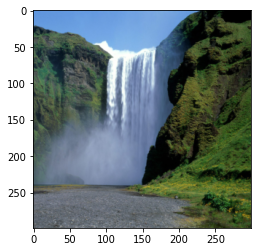

a group of people playing soccer on a field .
a group of people playing soccer on a field .
a group of young men playing soccer on a field .
a group of people playing soccer on a field .
a group of people playing soccer on a field .


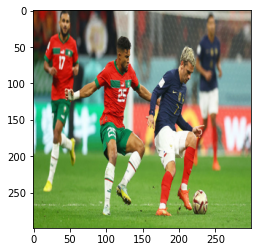

a person riding skis down a snow covered slope .
a man riding skis down a snow covered slope .
a man riding skis down a snowy hill .
a person riding skis down a snow covered slope .
a man riding skis down a snow covered slope .


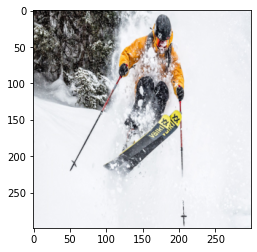

a man in a suit and tie is standing in front of a refrigerator .
a man in a suit and tie are sitting on a bench .
a man in a black shirt is looking at a cell phone .
a man in a suit and tie is standing in front of a window .
a man in a suit and tie is in a kitchen .


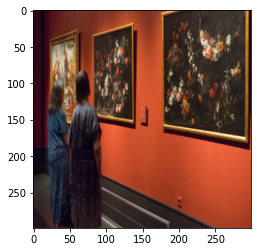

a kitchen with a stove top oven and a stove
a kitchen with a stove and a stove top oven .
a kitchen with a stove and a stove top oven .
a kitchen with a stove and a stove top oven .
a stove top oven with a refrigerator in it .


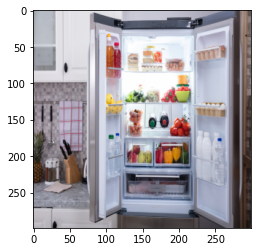

a large tree with a flower in the background .
a large tree with a large tree in the background .
a large tree with a tree in the background .
a large white bird sitting on top of a tree .
a large tree with a tree in the background .


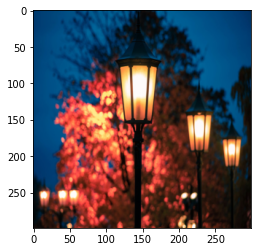

a white and white cat sitting on a table .
a small white and white cat sitting on a counter .
a white and white cat sitting on a table .
a white and white cat sitting on a table .
a white and white cat sitting on a table .


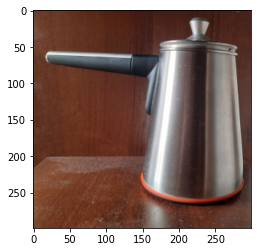

In [37]:
for i in images_10:
  for _ in range(5):
    print(generate_caption(i, t=5.))
  plt.imshow(i);
  plt.show()

We see that the descriptions for the pictures with a dog, a bird, cars, football players, mountain skis have almost turned out or turned out to be perfect

And it didn't work out at all with the waterfall, the paintings in the museum, the refrigerator, the lanterns in the park and the coffee cup.